In [1]:
import scipy.linalg
import scipy.optimize
import sys
import numpy as np
import importlib
import matplotlib.pyplot as plt
import scripts.theodolite_function as tfu
tfu = importlib.reload(tfu)
from scipy.interpolate import splprep, splev
from scipy import interpolate
import seaborn as sns
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from scipy.spatial.transform import Rotation as R
import time
from tqdm import tqdm
import scripts.theodolite_utils as tu
import scripts.resection_functions as rf
from scipy import stats
import random as rm
import math


Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
def simulate_cp(number_points, max_range):
    distance = []
    azimuth = []
    elevation = []
    for i in range(0,number_points):
        distance.append(rm.uniform(3, max_range))
        azimuth.append(rm.uniform(0, 2*math.pi))
        elevation.append(rm.uniform(math.pi*0.9, math.pi*1.1)) # +-10% of 90 degrees
    return distance, azimuth, elevation
        
def noise_cp(distance, azimuth, elevation, noise_range, noise_azimuth, noise_elevation):
    distance_noisy = []
    azimuth_noisy = []
    elevation_noisy = []
    for i,j,k in zip(distance, azimuth, elevation):
        distance_noisy.append(i+rm.gauss(noise_range[0], noise_range[1]))
        azimuth_noisy.append(j+rm.gauss(noise_azimuth[0], noise_azimuth[1]))
        elevation_noisy.append(k+rm.gauss(noise_elevation[0], noise_elevation[1]))
    return distance_noisy, azimuth_noisy, elevation_noisy

def raw_to_point(d1, a1, e1):
    p = []
    for i,j,k in zip(d1,a1,e1):
        p.append(tu.give_points_simulation(i,j,k,2))
    return p

def sort_from_range(d1, limit):
    index = []
    count = 0
    for i in d1:
        if(i>=limit[0] and i<=limit[1]):
            index.append(count)
        count+=1
    return np.array(index)

# Test cp simulation

In [51]:
tu = importlib.reload(tu)
rf = importlib.reload(rf)

rm.seed(100)
d1, a1, e1 = simulate_cp(200000, 320)

distance_test_max = np.arange(10,320, 20)
distance_test_min = np.zeros(len(distance_test_max))
#distance_test_min = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
#distance_test_max = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]
error_all = []
TF = []
number_points = []

for i,j in zip(distance_test_min,distance_test_max):

    index = sort_from_range(d1, [i,j])
    number_points.append(len(index))
    distance_sigma = 0.002
    angle_sigma = 0.0000157079632679 # 1 mgnon = 0.0000157079632679 rad
    d1n, a1n, e1n = noise_cp(np.array(d1)[index], np.array(a1)[index], np.array(e1)[index], [0,distance_sigma], [0,angle_sigma], [0,angle_sigma])
    d2n, a2n, e2n = noise_cp(np.array(d1)[index], np.array(a1)[index], np.array(e1)[index], [0,distance_sigma], [0,angle_sigma], [0,angle_sigma]) 
    d3n, a3n, e3n = noise_cp(np.array(d1)[index], np.array(a1)[index], np.array(e1)[index], [0,distance_sigma], [0,angle_sigma], [0,angle_sigma]) 
    
    p1n = np.array(raw_to_point(d1n, a1n, e1n)).T
    p2n = np.array(raw_to_point(d2n, a2n, e2n)).T
    p3n = np.array(raw_to_point(d3n, a3n, e3n)).T

    T1 = np.identity(4)
    T12 = rf.T_z(np.pi/2, [10,10,2])
    T13 = rf.T_z(-np.pi/2, [-20,10,-1])

    p1nn = T1@p1n
    p2nn = T12@p2n
    p3nn = T13@p3n
    
    T12_ptp = tu.point_to_point_minimization(p2nn, p1nn)
    T13_ptp = tu.point_to_point_minimization(p3nn, p1nn)
    
    TF.append([T12_ptp,T13_ptp])

    p1np = p1nn
    p2np = T12_ptp@p2nn
    p3np = T13_ptp@p3nn

    error = []
    rf.compute_error_between_points(p1np, p2np, p3np, error)
    error_all.append(error)


In [52]:
print(number_points)

[4424, 16930, 29649, 42269, 54728, 67529, 80360, 92721, 105324, 117993, 130577, 143239, 155813, 168385, 180999, 193677]


/home/norlab/python3-8_env/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


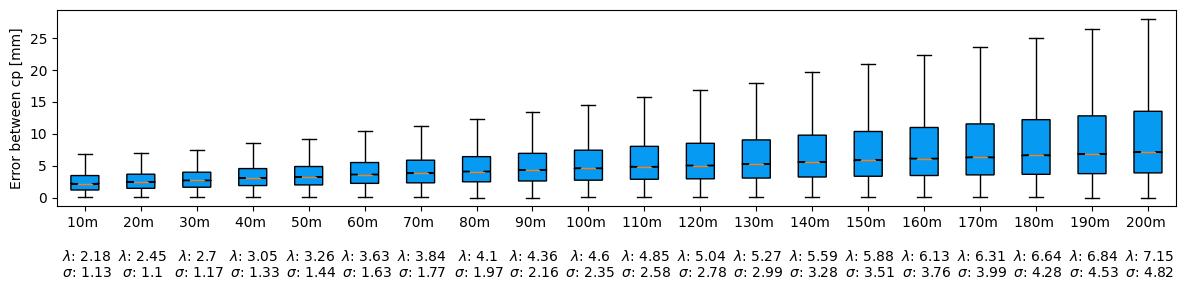

In [5]:
# Creating dataset
fig = plt.figure(figsize =(12, 3))
ax = fig.add_subplot(111)

result = error_all

box = ax.boxplot(error_all, notch=True, patch_artist=True, vert = 1, showfliers=False, showmeans=False)

plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], [
                          "10m \n\n $\lambda$: "+str(round(np.median(result[0]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[0], interpolation = 'midpoint')/2,2)),
                          "20m \n\n $\lambda$: "+str(round(np.median(result[1]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[1], interpolation = 'midpoint')/2,2)),
                          "30m \n\n $\lambda$: "+str(round(np.median(result[2]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[2], interpolation = 'midpoint')/2,2)),
                          "40m \n\n $\lambda$: "+str(round(np.median(result[3]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[3], interpolation = 'midpoint')/2,2)),
                          "50m \n\n $\lambda$: "+str(round(np.median(result[4]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[4], interpolation = 'midpoint')/2,2)),
                          "60m \n\n $\lambda$: "+str(round(np.median(result[5]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[5], interpolation = 'midpoint')/2,2)),
                          "70m \n\n $\lambda$: "+str(round(np.median(result[6]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[6], interpolation = 'midpoint')/2,2)),
                          "80m \n\n $\lambda$: "+str(round(np.median(result[7]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[7], interpolation = 'midpoint')/2,2)),
                          "90m \n\n $\lambda$: "+str(round(np.median(result[8]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[8], interpolation = 'midpoint')/2,2)),
                          "100m \n\n $\lambda$: "+str(round(np.median(result[9]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[9], interpolation = 'midpoint')/2,2)),
                          "110m \n\n $\lambda$: "+str(round(np.median(result[10]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[10], interpolation = 'midpoint')/2,2)),
                          "120m \n\n $\lambda$: "+str(round(np.median(result[11]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[11], interpolation = 'midpoint')/2,2)),
                          "130m \n\n $\lambda$: "+str(round(np.median(result[12]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[12], interpolation = 'midpoint')/2,2)),
                          "140m \n\n $\lambda$: "+str(round(np.median(result[13]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[13], interpolation = 'midpoint')/2,2)),
                          "150m \n\n $\lambda$: "+str(round(np.median(result[14]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[14], interpolation = 'midpoint')/2,2)),
                          "160m \n\n $\lambda$: "+str(round(np.median(result[15]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[15], interpolation = 'midpoint')/2,2)),
                          "170m \n\n $\lambda$: "+str(round(np.median(result[16]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[16], interpolation = 'midpoint')/2,2)),
                          "180m \n\n $\lambda$: "+str(round(np.median(result[17]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[17], interpolation = 'midpoint')/2,2)),
                          "190m \n\n $\lambda$: "+str(round(np.median(result[18]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[18], interpolation = 'midpoint')/2,2)),
                          "200m \n\n $\lambda$: "+str(round(np.median(result[19]),2))+" \n $\sigma$: "+str(round(stats.iqr(result[19], interpolation = 'midpoint')/2,2))
])

colors_box = ['#069AF3', '#069AF3', '#069AF3', '#069AF3', '#069AF3', 
              '#069AF3', '#069AF3', '#069AF3', '#069AF3', '#069AF3',
              '#069AF3', '#069AF3', '#069AF3', '#069AF3', '#069AF3',
              '#069AF3', '#069AF3', '#069AF3', '#069AF3', '#069AF3']

for patch, color in zip(box['boxes'], colors_box):
    patch.set_facecolor(color)
        
ax.set_ylabel("Error between cp [mm]")
fig.tight_layout()
plt.show()
#fig.savefig("./figs/Simulation_cp_error.jpg")


In [53]:
from scipy.spatial.transform import Rotation as R
T12 = rf.T_z(np.pi/2, [10,10,2])
T13 = rf.T_z(-np.pi/2, [-20,10,-1])
translation_12 = []
rotation_12 = []
translation_13 = []
rotation_13 = []
norm_error_12 = []
norm_error_13 = []
norm_error = []
for i in TF:
    tf12_corrected = T12@i[0]
    k = tf12_corrected
    r12 = k[0:3,0:3]
    r = R.from_matrix(r12)
    euler_12 = r.as_euler('xyz', degrees=False)
    translation_12.append(np.array([k[0,3],k[1,3],k[2,3]]))
    norm_error_12.append(np.linalg.norm(np.array([k[0,3],k[1,3],k[2,3]]))*1000)
    rotation_12.append(np.array([euler_12,euler_12,euler_12]))
    
    tf13_corrected = T13@i[1]
    k = tf13_corrected
    r13 = k[0:3,0:3]
    r = R.from_matrix(r13)
    euler_13 = r.as_euler('xyz', degrees=False)
    translation_13.append(np.array([k[0,3],k[1,3],k[2,3]]))
    norm_error_13.append(np.linalg.norm(np.array([k[0,3],k[1,3],k[2,3]]))*1000)
    rotation_13.append(np.array([euler_13,euler_13,euler_13]))
    
    norm_error.append(np.mean([norm_error_12[-1],norm_error_13[-1]]))


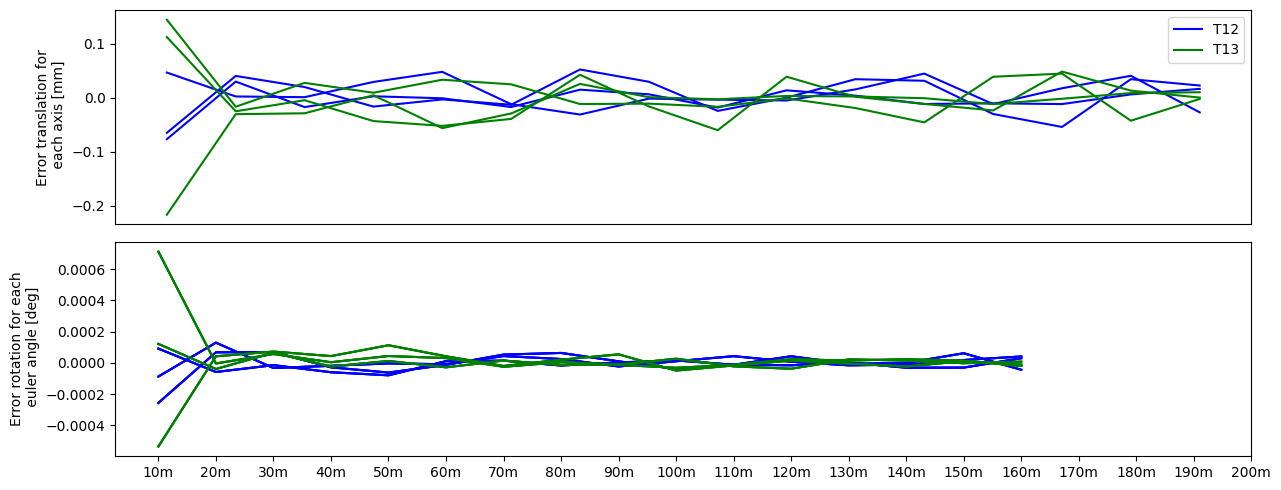

In [37]:
fig = plt.figure(figsize =(13, 5))
ax = fig.add_subplot(211)

ax.plot(np.array(translation_12)[:,0]*1000,color='b', label='T12')
ax.plot(np.array(translation_12)[:,1]*1000,color='b')
ax.plot(np.array(translation_12)[:,2]*1000,color='b')
ax.plot(np.array(translation_13)[:,0]*1000,color='g', label='T13')
ax.plot(np.array(translation_13)[:,1]*1000,color='g')
ax.plot(np.array(translation_13)[:,2]*1000,color='g')

ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off


ax.set_ylabel("Error translation for\n each axis [mm]")
ax.legend()

ax2 = fig.add_subplot(212)

ax2.plot(np.array(rotation_12)[:,0]*180/np.pi,color='b', label='T12')
ax2.plot(np.array(rotation_12)[:,1]*180/np.pi,color='b')
ax2.plot(np.array(rotation_12)[:,2]*180/np.pi,color='b')
ax2.plot(np.array(rotation_13)[:,0]*180/np.pi,color='g', label='T13')
ax2.plot(np.array(rotation_13)[:,1]*180/np.pi,color='g')
ax2.plot(np.array(rotation_13)[:,2]*180/np.pi,color='g')

ax2.set_ylabel("Error rotation for each\n euler angle [deg]")

plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [
    "10m","20m","30m","40m","50m","60m","70m","80m","90m","100m",
    "110m","120m","130m","140m","150m","160m","170m","180m","190m","200m"
])
fig.tight_layout()
plt.show()
#fig.savefig("./figs/Simulation_cp_error_tf.jpg")

/tmp/ipykernel_32244/2217346960.py:7: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1.append(np.percentile(value, 25, interpolation = 'midpoint'))
/tmp/ipykernel_32244/2217346960.py:8: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3.append(np.percentile(value, 75, interpolation = 'midpoint'))


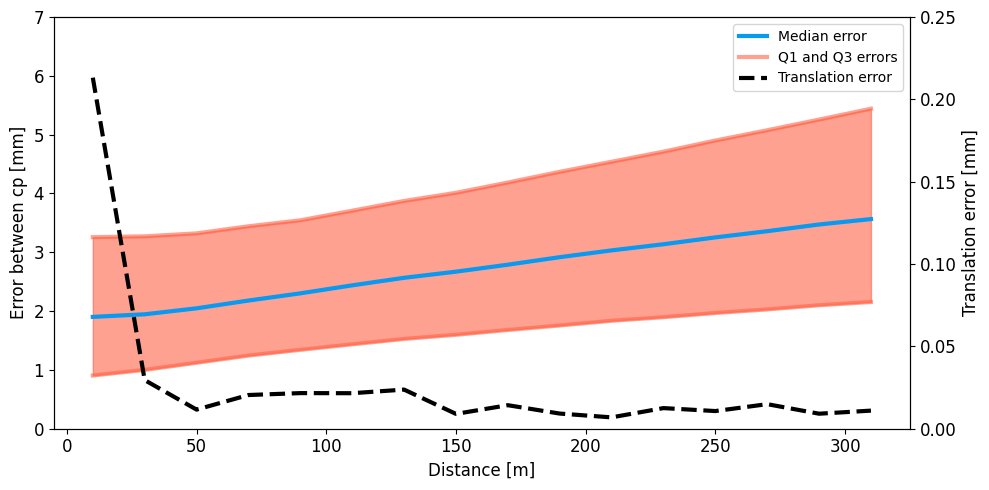

In [57]:
# Creating figure
median = []
Q1 = []
Q3 = []
for value in error_all:
    median.append(np.median(value))
    Q1.append(np.percentile(value, 25, interpolation = 'midpoint'))
    Q3.append(np.percentile(value, 75, interpolation = 'midpoint'))

x = distance_test_max
font_size = 12
fig = plt.figure(figsize =(10, 5))
ax = fig.add_subplot(111)
line1, = ax.plot(x, median, color = '#069AF3', linewidth=3, label = 'Median error')
line2, = ax.plot(x, Q1, color = 'tomato', alpha = 0.6, linewidth=3, label = 'Q1 and Q3 errors')
ax.plot(x, Q3, color = 'tomato', alpha = 0.6, linewidth=3)
ax.fill_between(x, Q1, median, color = 'tomato', alpha = 0.6)
ax.fill_between(x, Q3, median, color = 'tomato', alpha = 0.6)
ax.set_xlabel("Distance [m]",fontsize = font_size)
ax.set_ylabel("Error between cp [mm]",fontsize = font_size)
ax.set_ylim([0, 7])
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
ax2 = ax.twinx()
line3, = ax2.plot(x, norm_error, color='black', linestyle='dashed', linewidth=3, label = 'Translation error')
ax2.set_ylabel("Translation error [mm]",fontsize = font_size)
ax2.set_ylim([0, 0.25])
ax2.legend(loc='best', handles=[line1, line2, line3])
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
fig.tight_layout()
plt.show()
#fig.savefig("./figs/Simulation_cp_error_all.pdf")


# Test orientation influence

In [3]:
tu = importlib.reload(tu)
rf = importlib.reload(rf)

rm.seed(100)
distance_sigma = 0.002
angle_sigma = 0.0000157079632679 # 1 mgnon = 0.0000157079632679 rad
T1 = np.identity(4)
T12 = rf.T_z(np.pi/2, [10,10,2])

d1, a1, e1 = simulate_cp(100, 320)
d1r, a1r, e1r = noise_cp(np.array(d1), np.array(a1), np.array(e1), [0,distance_sigma], [0,angle_sigma], [0,angle_sigma])
d2r, a2r, e2r = noise_cp(np.array(d1), np.array(a1), np.array(e1), [0,distance_sigma], [0,angle_sigma], [0,angle_sigma]) 
p1r = np.array(raw_to_point(d1r, a1r, e1r)).T
p2r = np.array(raw_to_point(d2r, a2r, e2r)).T
p1rr = T1@p1r
p2rr = T12@p2r
T12r_ptp = tu.point_to_point_minimization(p2rr, p1rr)
r = R.from_matrix(T12r_ptp[0:3,0:3])
euler = r.as_euler('xyz', degrees=True)

perturbation_angle_yaw = np.arange(0, 100, 1)/10000
error_all_yaw = []
TF_yaw = []

for i in perturbation_angle_yaw:
    euler_corrected = euler
    euler_corrected[2] = euler[2] + i
    r = R.from_euler('xyz', [euler_corrected], degrees=True)
    R_corrected = r.as_matrix()
    T_corrected = T12r_ptp
    T_corrected[0:3,0:3] = R_corrected
    p2n = T_corrected@p2rr
    TF_yaw.append(T_corrected)
    error = []
    for value_1, value_2 in zip(p1rr.T,p2n.T):
        error_pos = np.linalg.norm(value_1[0:3]-value_2[0:3])*1000
        error.append(error_pos)
    error_all_yaw.append(error)


/tmp/ipykernel_1140/3747115659.py:7: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1.append(np.percentile(value, 25, interpolation = 'midpoint'))
/tmp/ipykernel_1140/3747115659.py:8: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3.append(np.percentile(value, 75, interpolation = 'midpoint'))


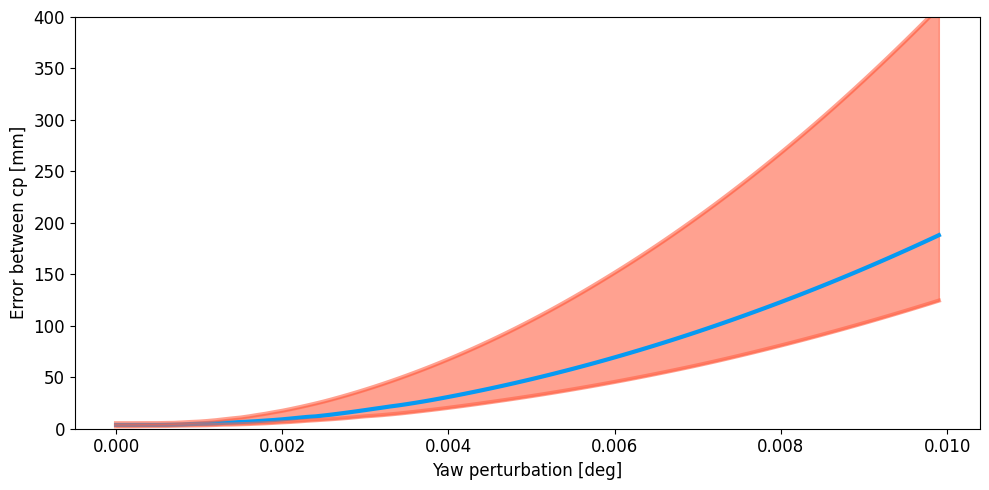

In [22]:
# Creating figure
median = []
Q1 = []
Q3 = []
for value in error_all_yaw:
    median.append(np.median(value))
    Q1.append(np.percentile(value, 25, interpolation = 'midpoint'))
    Q3.append(np.percentile(value, 75, interpolation = 'midpoint'))

x = perturbation_angle_yaw
font_size = 12
fig = plt.figure(figsize =(10, 5))
ax = fig.add_subplot(111)
line1, = ax.plot(x, median, color = '#069AF3', linewidth=3, label = 'Median error')
line2, = ax.plot(x, Q1, color = 'tomato', alpha = 0.6, linewidth=3, label = 'Q1 and Q3 errors')
ax.plot(x, Q3, color = 'tomato', alpha = 0.6, linewidth=3)
ax.fill_between(x, Q1, median, color = 'tomato', alpha = 0.6)
ax.fill_between(x, Q3, median, color = 'tomato', alpha = 0.6)
ax.set_xlabel("Yaw perturbation [deg]",fontsize = font_size)
ax.set_ylabel("Error between cp [mm]",fontsize = font_size)
ax.set_ylim([0, 400])
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
fig.tight_layout()
plt.show()
#fig.savefig("./figs/Simulation_cp_error_all.pdf")


In [5]:
tu = importlib.reload(tu)
rf = importlib.reload(rf)

rm.seed(100)
distance_sigma = 0.002
angle_sigma = 0.0000157079632679 # 1 mgnon = 0.0000157079632679 rad
T1 = np.identity(4)
T12 = rf.T_z(np.pi/2, [10,10,2])

d1, a1, e1 = simulate_cp(500, 320)
d1r, a1r, e1r = noise_cp(np.array(d1), np.array(a1), np.array(e1), [0,distance_sigma], [0,angle_sigma], [0,angle_sigma])
d2r, a2r, e2r = noise_cp(np.array(d1), np.array(a1), np.array(e1), [0,distance_sigma], [0,angle_sigma], [0,angle_sigma]) 
p1r = np.array(raw_to_point(d1r, a1r, e1r)).T
p2r = np.array(raw_to_point(d2r, a2r, e2r)).T
p1rr = T1@p1r
p2rr = T12@p2r
T12r_ptp = tu.point_to_point_minimization(p2rr, p1rr)
r = R.from_matrix(T12r_ptp[0:3,0:3])
euler = r.as_euler('xyz', degrees=True)

perturbation_angle_pitch = np.arange(0, 100, 1)/100000
error_all_pitch = []
TF_pitch = []

for i in perturbation_angle_pitch:
    euler_corrected = euler
    euler_corrected[1] = euler[1] + i
    r = R.from_euler('xyz', [euler_corrected], degrees=True)
    R_corrected = r.as_matrix()
    T_corrected = T12r_ptp
    T_corrected[0:3,0:3] = R_corrected
    p2n = T_corrected@p2rr
    TF_pitch.append(T_corrected)
    error = []
    for value_1, value_2 in zip(p1rr.T,p2n.T):
        error_pos = np.linalg.norm(value_1[0:3]-value_2[0:3])*1000
        error.append(error_pos)
    error_all_pitch.append(error)


/tmp/ipykernel_32244/3104339433.py:7: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1.append(np.percentile(value, 25, interpolation = 'midpoint'))
/tmp/ipykernel_32244/3104339433.py:8: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3.append(np.percentile(value, 75, interpolation = 'midpoint'))


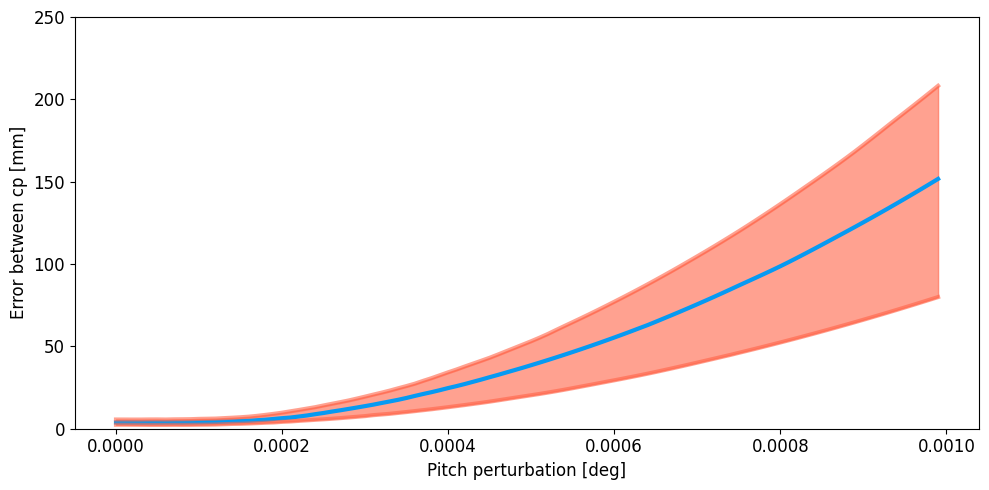

In [126]:
# Creating figure
median = []
Q1 = []
Q3 = []
for value in error_all_pitch:
    median.append(np.median(value))
    Q1.append(np.percentile(value, 25, interpolation = 'midpoint'))
    Q3.append(np.percentile(value, 75, interpolation = 'midpoint'))

x = perturbation_angle_pitch
font_size = 12
fig = plt.figure(figsize =(10, 5))
ax = fig.add_subplot(111)
line1, = ax.plot(x, median, color = '#069AF3', linewidth=3, label = 'Median error')
line2, = ax.plot(x, Q1, color = 'tomato', alpha = 0.6, linewidth=3, label = 'Q1 and Q3 errors')
ax.plot(x, Q3, color = 'tomato', alpha = 0.6, linewidth=3)
ax.fill_between(x, Q1, median, color = 'tomato', alpha = 0.6)
ax.fill_between(x, Q3, median, color = 'tomato', alpha = 0.6)
ax.set_xlabel("Pitch perturbation [deg]",fontsize = font_size)
ax.set_ylabel("Error between cp [mm]",fontsize = font_size)
ax.set_ylim([0, 250])
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
fig.tight_layout()
plt.show()
#fig.savefig("./figs/Simulation_cp_error_all.pdf")


In [92]:
tu = importlib.reload(tu)
rf = importlib.reload(rf)

rm.seed(100)
distance_sigma = 0.002
angle_sigma = 0.0000157079632679 # 1 mgnon = 0.0000157079632679 rad
T1 = np.identity(4)
T12 = rf.T_z(np.pi/2, [10,10,2])

d1, a1, e1 = simulate_cp(500, 320)
d1r, a1r, e1r = noise_cp(np.array(d1), np.array(a1), np.array(e1), [0,distance_sigma], [0,angle_sigma], [0,angle_sigma])
d2r, a2r, e2r = noise_cp(np.array(d1), np.array(a1), np.array(e1), [0,distance_sigma], [0,angle_sigma], [0,angle_sigma]) 
p1r = np.array(raw_to_point(d1r, a1r, e1r)).T
p2r = np.array(raw_to_point(d2r, a2r, e2r)).T
p1rr = T1@p1r
p2rr = T12@p2r
T12r_ptp = tu.point_to_point_minimization(p2rr, p1rr)
r = R.from_matrix(T12r_ptp[0:3,0:3])
euler = r.as_euler('xyz', degrees=True)

perturbation_angle_roll = np.arange(0, 100, 1)/100000
print(perturbation_angle_roll)
error_all_roll = []
TF_roll = []

for i in perturbation_angle_roll:
    euler_corrected = euler
    euler_corrected[0] = euler[0] + i
    r = R.from_euler('xyz', euler_corrected, degrees=True)
    R_corrected = r.as_matrix()
    T_corrected = T12r_ptp
    T_corrected[0:3,0:3] = R_corrected
    p2n = T_corrected@p2rr
    TF_roll.append(T_corrected)
    error = []
    for value_1, value_2 in zip(p1rr.T,p2n.T):
        error_pos = np.linalg.norm(value_1[0:3]-value_2[0:3])*1000
        error.append(error_pos)
    error_all_roll.append(error)


[0.0e+00 1.0e-05 2.0e-05 3.0e-05 4.0e-05 5.0e-05 6.0e-05 7.0e-05 8.0e-05
 9.0e-05 1.0e-04 1.1e-04 1.2e-04 1.3e-04 1.4e-04 1.5e-04 1.6e-04 1.7e-04
 1.8e-04 1.9e-04 2.0e-04 2.1e-04 2.2e-04 2.3e-04 2.4e-04 2.5e-04 2.6e-04
 2.7e-04 2.8e-04 2.9e-04 3.0e-04 3.1e-04 3.2e-04 3.3e-04 3.4e-04 3.5e-04
 3.6e-04 3.7e-04 3.8e-04 3.9e-04 4.0e-04 4.1e-04 4.2e-04 4.3e-04 4.4e-04
 4.5e-04 4.6e-04 4.7e-04 4.8e-04 4.9e-04 5.0e-04 5.1e-04 5.2e-04 5.3e-04
 5.4e-04 5.5e-04 5.6e-04 5.7e-04 5.8e-04 5.9e-04 6.0e-04 6.1e-04 6.2e-04
 6.3e-04 6.4e-04 6.5e-04 6.6e-04 6.7e-04 6.8e-04 6.9e-04 7.0e-04 7.1e-04
 7.2e-04 7.3e-04 7.4e-04 7.5e-04 7.6e-04 7.7e-04 7.8e-04 7.9e-04 8.0e-04
 8.1e-04 8.2e-04 8.3e-04 8.4e-04 8.5e-04 8.6e-04 8.7e-04 8.8e-04 8.9e-04
 9.0e-04 9.1e-04 9.2e-04 9.3e-04 9.4e-04 9.5e-04 9.6e-04 9.7e-04 9.8e-04
 9.9e-04]


/tmp/ipykernel_1140/2198064250.py:7: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1.append(np.percentile(value, 25, interpolation = 'midpoint'))
/tmp/ipykernel_1140/2198064250.py:8: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3.append(np.percentile(value, 75, interpolation = 'midpoint'))


<IPython.core.display.Javascript object>


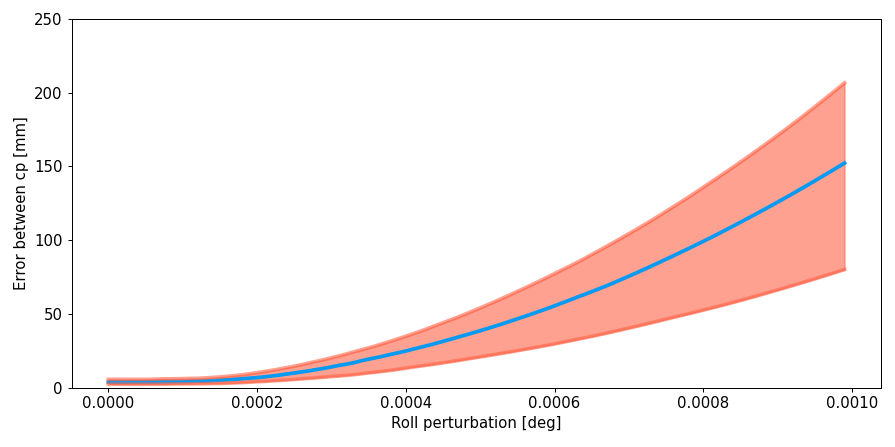

In [93]:
# Creating figure
median = []
Q1 = []
Q3 = []
for value in error_all_roll:
    median.append(np.median(value))
    Q1.append(np.percentile(value, 25, interpolation = 'midpoint'))
    Q3.append(np.percentile(value, 75, interpolation = 'midpoint'))

x = perturbation_angle_roll
font_size = 12
fig = plt.figure(figsize =(10, 5))
ax = fig.add_subplot(111)
line1, = ax.plot(x, median, color = '#069AF3', linewidth=3, label = 'Median error')
line2, = ax.plot(x, Q1, color = 'tomato', alpha = 0.6, linewidth=3, label = 'Q1 and Q3 errors')
ax.plot(x, Q3, color = 'tomato', alpha = 0.6, linewidth=3)
ax.fill_between(x, Q1, median, color = 'tomato', alpha = 0.6)
ax.fill_between(x, Q3, median, color = 'tomato', alpha = 0.6)
ax.set_xlabel("Roll perturbation [deg]",fontsize = font_size)
ax.set_ylabel("Error between cp [mm]",fontsize = font_size)
ax.set_ylim([0, 250])
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
fig.tight_layout()
plt.show()
#fig.savefig("./figs/Simulation_cp_error_all.pdf")


In [5]:
tu = importlib.reload(tu)
rf = importlib.reload(rf)

cp_text_file = "TF_list_static_cp.csv"
ip_text_file = "TF_list_linear_inter_prism_6dof.csv"
path = "./data/TF_lists/"

repo_tf_file_cp = [
    path+"20220224/"+cp_text_file,        #0
    path+"20220307/"+cp_text_file,        # 1
    path+"20220314/"+cp_text_file,        #2
    path+"20220316/"+cp_text_file,        #3
    path+"20220331/01/"+cp_text_file,        #4
    path+"20220331/02/"+cp_text_file,        #5
    path+"20220505/cones/"+cp_text_file,        #6   bad
    path+"20220505/empty/"+cp_text_file,        #7   bad
    path+"20220513/morning_lidar/01/"+cp_text_file,        #8
    path+"20220513/morning_without_lidar_1/"+cp_text_file,        #9
    path+"20220513/morning_without_lidar_2/"+cp_text_file,        #10
    path+"20220513/evening_lidar/"+cp_text_file,        #11
    path+"20220513/evening_without_lidar_2/"+cp_text_file,        #12
    path+"20220523/cones/"+cp_text_file,        #13  bad
    path+"20220523/constrained/"+cp_text_file,        #14  bad
    path+"20220523/empty/"+cp_text_file,        #15
    path+"20220523/other_tunnel/"+cp_text_file,        #16   bad       
    path+"20220622/01/01/"+cp_text_file,        #17
    path+"20220622/02/02/"+cp_text_file,        #18
    path+"20220630/01/"+cp_text_file,        #19
    path+"20220630/02/"+cp_text_file,        #20
    path+"20220711/"+cp_text_file,        #21
    path+"20220717/02/"+cp_text_file,        #22   bad
    path+"20220717/02/"+cp_text_file,        #23
    path+"20220717/02/"+cp_text_file        #24    bad
]
repo_tf_file_ip = [
    path+"20220224/"+ip_text_file,
    path+"20220307/"+ip_text_file,
    path+"20220314/"+ip_text_file,
    path+"20220316/"+ip_text_file,
    path+"20220331/01/"+ip_text_file,
    path+"20220331/02/"+ip_text_file,
    path+"20220505/cones/"+ip_text_file,
    path+"20220505/empty/"+ip_text_file,
    path+"20220513/morning_lidar/"+ip_text_file,
    path+"20220513/morning_without_lidar_1/"+ip_text_file,
    path+"20220513/morning_without_lidar_2/"+ip_text_file,
    path+"20220513/evening_lidar/"+ip_text_file,
    path+"20220513/evening_without_lidar_2/"+ip_text_file,
    path+"20220523/cones/"+ip_text_file,
    path+"20220523/constrained/"+ip_text_file,
    path+"20220523/empty/"+ip_text_file,
    path+"20220523/other_tunnel/"+ip_text_file,
    path+"20220622/01/"+ip_text_file,
    path+"20220622/02/"+ip_text_file,
    path+"20220630/01/"+ip_text_file,
    path+"20220630/02/"+ip_text_file,
    path+"20220711/"+ip_text_file,
    path+"20220717/02/"+ip_text_file,
    path+"20220717/03/"+ip_text_file,
    path+"20220717/04/"+ip_text_file
]

Tf_cp = []
Tf_ip = []
for i,j in zip(repo_tf_file_cp,repo_tf_file_ip):
    Tf_cp_read = np.array(tu.read_saved_tf(i))
    Tf_ip_read = np.array(tu.read_saved_tf(j))
    Tf_cp.append(Tf_cp_read[0])
    Tf_cp.append(Tf_cp_read[1])
    Tf_cp.append(Tf_cp_read[2])
    Tf_ip.append(Tf_ip_read[0])
    Tf_ip.append(Tf_ip_read[1])
    Tf_ip.append(Tf_ip_read[2])

TF_cp_12 = []
TF_cp_13 = []
TF_ip_12 = []
TF_ip_13 = []
error_rotation_12 = []
error_rotation_13 = []
error_translation_12 = []
error_translation_13 = []

count = 0
for i,j in zip(Tf_cp,Tf_ip):
    if(count%3==1):
        TF_cp_12.append(i)
        TF_ip_12.append(j)
        r_cp = R.from_matrix(i[0:3,0:3])
        r_ip = R.from_matrix(j[0:3,0:3])
        euler_cp = r_cp.as_euler('xyz', degrees=True)
        euler_ip = r_ip.as_euler('xyz', degrees=True)
        error_rotation_12.append(abs(euler_cp-euler_ip))
        error_translation_12.append(np.absolute(i[0:3,3]-j[0:3,3])*1000)
    if(count%3==2):
        TF_cp_13.append(i)
        TF_ip_13.append(j)
        r_cp = R.from_matrix(i[0:3,0:3])
        r_ip = R.from_matrix(j[0:3,0:3])
        euler_cp = r_cp.as_euler('xyz', degrees=True)
        euler_ip = r_ip.as_euler('xyz', degrees=True)
        error_rotation_13.append(abs(euler_cp-euler_ip))
        error_translation_13.append(np.absolute(i[0:3,3]-j[0:3,3])*1000)
    count+=1
    
print(error_translation_12)

[array([1.57807066, 1.98762731, 3.8405363 ]), array([3.88070021, 3.12125151, 9.71668723]), array([6.29860822, 5.24941435, 2.71676991]), array([ 1.13913343,  4.46672598, 30.28266743]), array([1.10190383, 3.92423287, 3.58337092]), array([ 2.1800398 ,  3.89604962, 25.45929574]), array([  6.53155214, 114.53866398,  96.28010293]), array([  7.48990414, 110.53676734,  96.20860774]), array([ 0.09250996, 13.43683911,  7.5282472 ]), array([4.87800441, 7.40678074, 3.263147  ]), array([6.5115712 , 1.92017181, 1.6267372 ]), array([4.90195076, 2.95611659, 3.5405119 ]), array([2.58415329, 4.69172054, 5.85949785]), array([20.54557937,  7.39527628,  4.45795322]), array([48.51976445,  8.27677744, 18.65633681]), array([ 2.90099404,  2.12472738, 12.53253326]), array([32.07149999, 55.31529831, 48.90617797]), array([ 0.40153581,  1.14430003, 11.55078123]), array([ 1.86350988,  7.13838939, 21.03870045]), array([ 1.22657505,  5.2099247 , 10.05480449]), array([2.76142704, 7.98488863, 6.38660037]), array([0.258

2.761427042001774
5.209924696770729
9.716687231457966
13.03819860115671


<IPython.core.display.Javascript object>


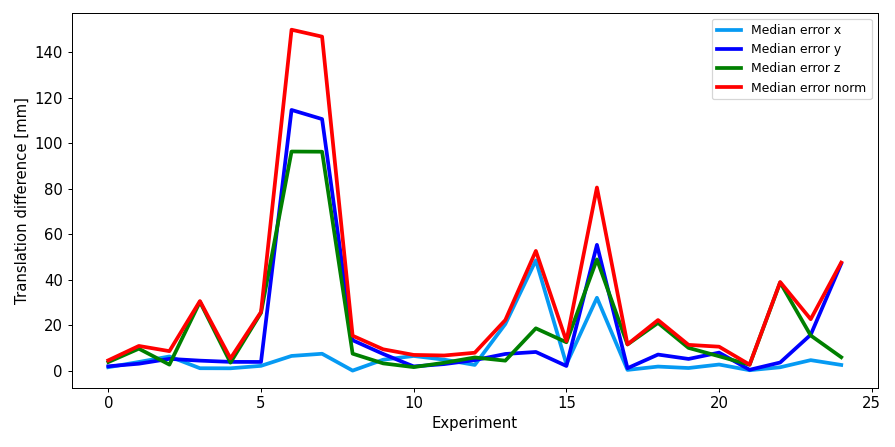

In [6]:
%matplotlib notebook
# Creating figure
error_x_12 = []
error_y_12 = []
error_z_12 = []
norm_error_12 = []
for value in error_translation_12:
    norm_error_12.append(np.linalg.norm(value))
    median = np.median(value[0])
    error_x_12.append(median)
    median = np.median(value[1])
    error_y_12.append(median)
    median = np.median(value[2])
    error_z_12.append(median)

error_x_12_arr = np.array(error_x_12)
error_y_12_arr = np.array(error_y_12)
error_z_12_arr = np.array(error_z_12)
norm_error_12_arr = np.array(norm_error_12)
print(np.median(error_x_12_arr))
print(np.median(error_y_12_arr))
print(np.median(error_z_12_arr))
print(np.median(norm_error_12_arr))

x = np.arange(0,len(error_x_12))
font_size = 12
fig = plt.figure(figsize =(10, 5))
ax = fig.add_subplot(111)
line1, = ax.plot(x, error_x_12_arr, color = '#069AF3', linewidth=3, label = 'Median error x')
line2, = ax.plot(x, error_y_12_arr, color = 'b', linewidth=3, label = 'Median error y')
line3, = ax.plot(x, error_z_12_arr, color = 'g', linewidth=3, label = 'Median error z')
line4, = ax.plot(x, norm_error_12_arr, color = 'r', linewidth=3, label = 'Median error norm')
#line2, = ax.plot(x, error_x_12_arr[:,1], color = 'tomato', alpha = 0.6, linewidth=3, label = 'Q1 and Q3 errors')
#ax.plot(x, error_x_12_arr[:,2], color = 'tomato', alpha = 0.6, linewidth=3)
#ax.fill_between(x, error_x_12_arr[:,1], error_x_12_arr[:,0], color = 'tomato', alpha = 0.6)
#ax.fill_between(x, error_x_12_arr[:,2], error_x_12_arr[:,0], color = 'tomato', alpha = 0.6)
ax.set_xlabel("Experiment",fontsize = font_size)
ax.set_ylabel("Translation difference [mm]",fontsize = font_size)
#ax.set_ylim([0, 50])
ax.legend()
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
fig.tight_layout()
plt.show()

6.619175525010457
4.358190987458599
11.226895608496768
14.286170362761775


<IPython.core.display.Javascript object>


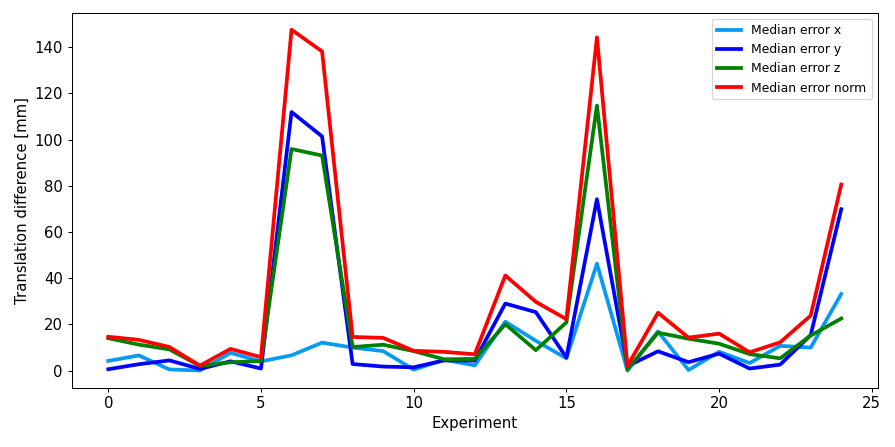

In [7]:
%matplotlib notebook
# Creating figure
error_x_13 = []
error_y_13 = []
error_z_13 = []
norm_error_13 = []
for value in error_translation_13:
    norm_error_13.append(np.linalg.norm(value))
    median = np.median(value[0])
    error_x_13.append(median)
    median = np.median(value[1])
    error_y_13.append(median)
    median = np.median(value[2])
    error_z_13.append(median)

error_x_13_arr = np.array(error_x_13)
error_y_13_arr = np.array(error_y_13)
error_z_13_arr = np.array(error_z_13)
norm_error_13_arr = np.array(norm_error_13)
print(np.median(error_x_13_arr))
print(np.median(error_y_13_arr))
print(np.median(error_z_13_arr))
print(np.median(norm_error_13_arr))

x = np.arange(0,len(error_x_13))
font_size = 12
fig = plt.figure(figsize =(10, 5))
ax = fig.add_subplot(111)
line1, = ax.plot(x, error_x_13_arr, color = '#069AF3', linewidth=3, label = 'Median error x')
line2, = ax.plot(x, error_y_13_arr, color = 'b', linewidth=3, label = 'Median error y')
line3, = ax.plot(x, error_z_13_arr, color = 'g', linewidth=3, label = 'Median error z')
line4, = ax.plot(x, norm_error_13_arr, color = 'r', linewidth=3, label = 'Median error norm')
#line2, = ax.plot(x, error_x_12_arr[:,1], color = 'tomato', alpha = 0.6, linewidth=3, label = 'Q1 and Q3 errors')
#ax.plot(x, error_x_12_arr[:,2], color = 'tomato', alpha = 0.6, linewidth=3)
#ax.fill_between(x, error_x_12_arr[:,1], error_x_12_arr[:,0], color = 'tomato', alpha = 0.6)
#ax.fill_between(x, error_x_12_arr[:,2], error_x_12_arr[:,0], color = 'tomato', alpha = 0.6)
ax.set_xlabel("Experiment",fontsize = font_size)
ax.set_ylabel("Translation difference [mm]",fontsize = font_size)
#ax.set_ylim([0, 50])
ax.legend()
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
fig.tight_layout()
plt.show()

0.024717711905919423
0.02891760414160697
0.01288224918873837


<IPython.core.display.Javascript object>


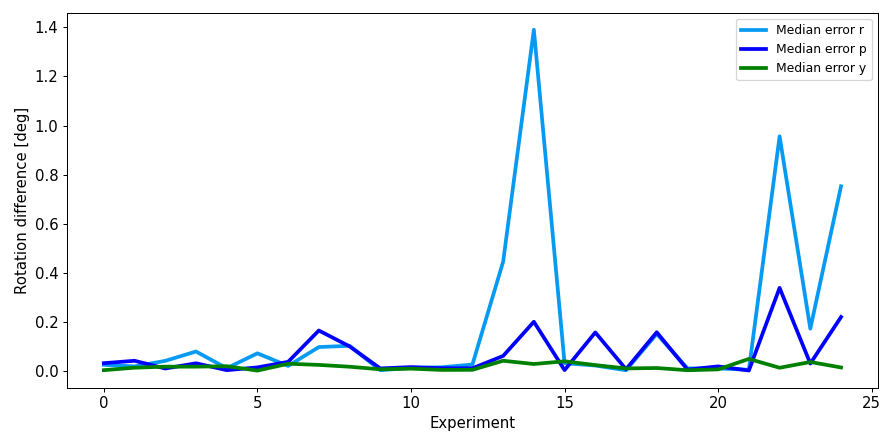

In [9]:
%matplotlib notebook
# Creating figure
error_r_12 = []
error_p_12 = []
error_y_12 = []
for value in error_rotation_12:
    median = np.median(value[0])
    error_r_12.append(median)
    median = np.median(value[1])
    error_p_12.append(median)
    median = np.median(value[2])
    error_y_12.append(median)

error_r_12_arr = np.array(error_r_12)
error_p_12_arr = np.array(error_p_12)
error_y_12_arr = np.array(error_y_12)
print(np.median(error_r_12_arr))
print(np.median(error_p_12_arr))
print(np.median(error_y_12_arr))

x = np.arange(0,len(error_r_12))
font_size = 12
fig = plt.figure(figsize =(10, 5))
ax = fig.add_subplot(111)
line1, = ax.plot(x, error_r_12_arr, color = '#069AF3', linewidth=3, label = 'Median error r')
line2, = ax.plot(x, error_p_12_arr, color = 'b', linewidth=3, label = 'Median error p')
line3, = ax.plot(x, error_y_12_arr, color = 'g', linewidth=3, label = 'Median error y')
#line2, = ax.plot(x, error_x_12_arr[:,1], color = 'tomato', alpha = 0.6, linewidth=3, label = 'Q1 and Q3 errors')
#ax.plot(x, error_x_12_arr[:,2], color = 'tomato', alpha = 0.6, linewidth=3)
#ax.fill_between(x, error_x_12_arr[:,1], error_x_12_arr[:,0], color = 'tomato', alpha = 0.6)
#ax.fill_between(x, error_x_12_arr[:,2], error_x_12_arr[:,0], color = 'tomato', alpha = 0.6)
ax.set_xlabel("Experiment",fontsize = font_size)
ax.set_ylabel("Rotation difference [deg]",fontsize = font_size)
#ax.set_ylim([0, 50])
ax.legend()
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
fig.tight_layout()
plt.show()

0.049479902762875755
0.030448591654874315
0.0066332381799867335


<IPython.core.display.Javascript object>


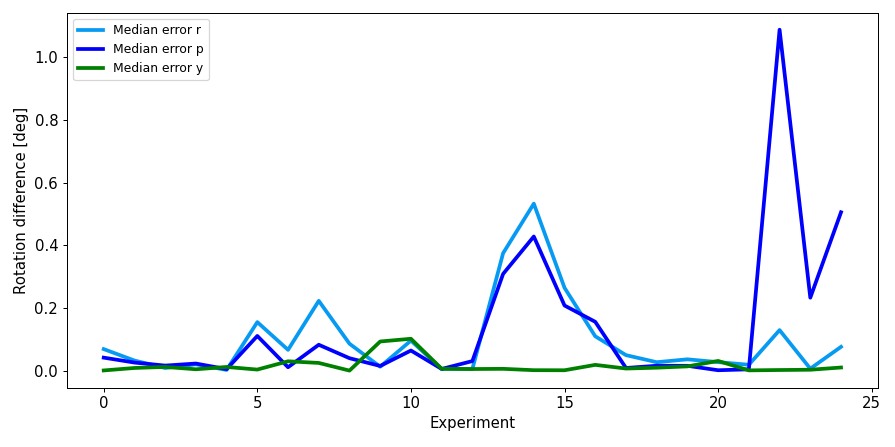

In [10]:
%matplotlib notebook
# Creating figure
error_r_13 = []
error_p_13 = []
error_y_13 = []
for value in error_rotation_13:
    median = np.median(value[0])
    error_r_13.append(median)
    median = np.median(value[1])
    error_p_13.append(median)
    median = np.median(value[2])
    error_y_13.append(median)

error_r_13_arr = np.array(error_r_13)
error_p_13_arr = np.array(error_p_13)
error_y_13_arr = np.array(error_y_13)
print(np.median(error_r_13_arr))
print(np.median(error_p_13_arr))
print(np.median(error_y_13_arr))

x = np.arange(0,len(error_r_13))
font_size = 12
fig = plt.figure(figsize =(10, 5))
ax = fig.add_subplot(111)
line1, = ax.plot(x, error_r_13_arr, color = '#069AF3', linewidth=3, label = 'Median error r')
line2, = ax.plot(x, error_p_13_arr, color = 'b', linewidth=3, label = 'Median error p')
line3, = ax.plot(x, error_y_13_arr, color = 'g', linewidth=3, label = 'Median error y')
#line2, = ax.plot(x, error_x_12_arr[:,1], color = 'tomato', alpha = 0.6, linewidth=3, label = 'Q1 and Q3 errors')
#ax.plot(x, error_x_12_arr[:,2], color = 'tomato', alpha = 0.6, linewidth=3)
#ax.fill_between(x, error_x_12_arr[:,1], error_x_12_arr[:,0], color = 'tomato', alpha = 0.6)
#ax.fill_between(x, error_x_12_arr[:,2], error_x_12_arr[:,0], color = 'tomato', alpha = 0.6)
ax.set_xlabel("Experiment",fontsize = font_size)
ax.set_ylabel("Rotation difference [deg]",fontsize = font_size)
#ax.set_ylim([0, 50])
ax.legend()
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
fig.tight_layout()
plt.show()